In [3]:
from fastai2.collab import *
from fastai2.tabular.all import *
path = untar_data(URLs.ML_100k)

In [4]:
#path.ls() # Check details on https://grouplens.org/datasets/movielens/     (Movielens100K dataset)

##u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
##              Each user has rated at least 20 movies.  Users and items are
##              numbered consecutively from 1.  The data is randomly
##              ordered. This is a tab separated list of 
##	         user id | item id | rating | timestamp. 
##              The time stamps are unix seconds since 1/1/1970 UTC   

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header = None, names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
movies = pd.read_csv(path/'u.item', delimiter = '|', encoding = 'latin-1',usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,141,Romy and Michele's High School Reunion (1997),3
1,394,Robin Hood: Prince of Thieves (1991),5
2,130,Candyman (1992),5
3,844,Chain Reaction (1996),2
4,18,"Full Monty, The (1997)",5
5,826,Under Siege 2: Dark Territory (1995),3
6,561,"Sex, Lies, and Videotape (1989)",3
7,638,M*A*S*H (1970),4
8,932,Cool Hand Luke (1967),4
9,13,Schindler's List (1993),3


In [9]:
dls.classes

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1629) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

In [9]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors=5

user_factors=torch.randn(n_users,n_factors)
movie_factors=torch.randn(n_movies, n_factors)

In [26]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [13]:
x,y=dls.one_batch()
x.shape

torch.Size([64, 2])

In [27]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [28]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.331382,1.256289,00:10
1,1.084467,1.084707,00:10
2,0.948693,0.968534,00:10
3,0.835739,0.881830,00:10
4,0.783863,0.863466,00:10


In [29]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self,x):
        users=self.user_factors(x[:,0])
        movies=self.movie_factors(x[:,1])
        return sigmoid_range((users*movies).sum(dim=1), *self.y_range)
        

In [30]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.982067,0.963037,00:10
1,0.875665,0.899062,00:10
2,0.695697,0.865018,00:10
3,0.500569,0.876244,00:10
4,0.366047,0.881515,00:10


In [40]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [33]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.987246,0.968482,00:10
1,0.861576,0.890092,00:10
2,0.669772,0.858569,00:10
3,0.499944,0.869082,00:10
4,0.379880,0.873653,00:10


In [42]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.966767,0.940231,00:11
1,0.871167,0.868433,00:11
2,0.726105,0.821811,00:11
3,0.582873,0.811392,00:11
4,0.491866,0.812752,00:11


In [43]:
learn.fit_one_cycle(5, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,time
0,0.643194,0.845937,00:11
1,0.750119,0.848669,00:11
2,0.705857,0.827927,00:11
3,0.622380,0.818409,00:11
4,0.509123,0.816907,00:11


In [10]:
def create_params(size):                                     #this is embedding
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [11]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [46]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,time
0,0.934931,0.947924,00:10
1,0.893318,0.884595,00:10
2,0.863673,0.843335,00:10
3,0.738572,0.815252,00:10
4,0.650689,0.812492,00:10


In [53]:
movie_bias = learn.model.movie_bias.squeeze()
idxs=movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Crow: City of Angels, The (1996)',
 'Robocop 3 (1993)',
 'Mortal Kombat: Annihilation (1997)']

In [55]:
idx=movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Crow: City of Angels, The (1996)',
 'Robocop 3 (1993)',
 'Mortal Kombat: Annihilation (1997)']

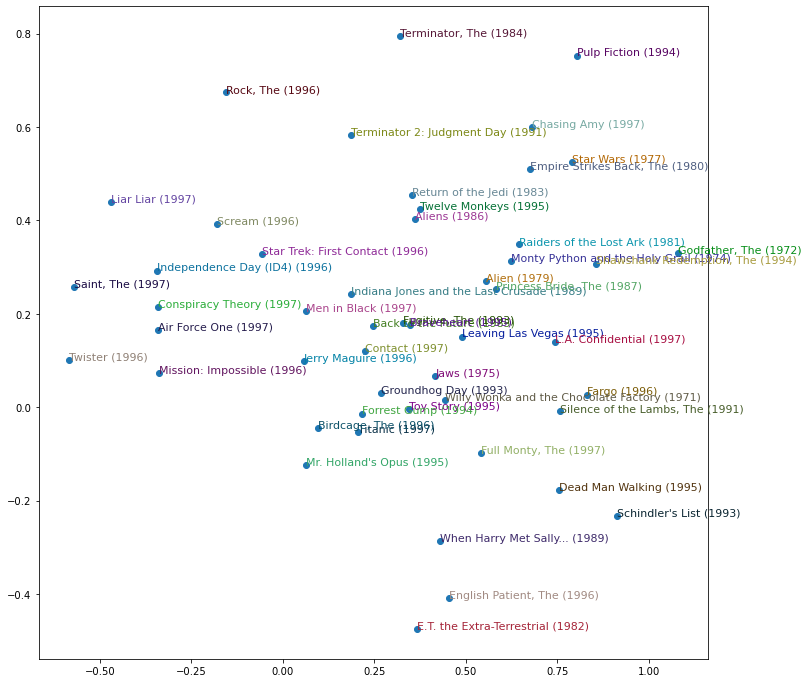

In [56]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [57]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [58]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.951130,0.918931,00:11
1,0.853793,0.863965,00:11
2,0.748694,0.821460,00:11
3,0.585541,0.809857,00:11
4,0.480915,0.810872,00:11


In [59]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1633, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1633, 1)
)

In [60]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Apt Pupil (1998)']

In [61]:
movie_factors = learn.model.i_weight.weight   #weight gives proximity to defined movie? what is the parameter here?
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

"Schindler's List (1993)"

In [12]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),   #why user_sz[1]
            nn.ReLU(),
            nn.Linear(n_act,1))
        self.y_range = y_range
        
    def forward(self,x):
        embs=self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x=self.layers(torch.cat(embs,dim=1))
        return sigmoid_range(x, *self.y_range)

In [14]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1629, 101)]

In [15]:
model = CollabNN(*embs)

In [16]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.936779,0.946258,00:13
1,0.874895,0.896128,00:13
2,0.879759,0.875138,00:13
3,0.822590,0.855243,00:13
4,0.760100,0.856264,00:13


In [19]:
learn = collab_learner(dls, use_nn=True, y_range=(0,5.5),layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.024350,0.960530,00:18
1,0.911480,0.902213,00:18
2,0.866363,0.869393,00:18
3,0.801528,0.851420,00:18
4,0.773312,0.851845,00:17


In [20]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers, n_cont=0, out_sz=1, **kwargs)